# Convolutional Autoencoders


An autoencoder is a type of neural network architecture that aims to copy its input to its output by learning an efficient, compressed representation of the data. It functions through two main components: an encoder that compresses the input into a low dimensional layer, also known as a latent space, and a decoder that attempts to reconstruct the original input from that compressed layer. By forcing the data through this bottleneck, the network cannot just memorize the input, instead, it learns the most essential features, patterns, and structures to achieve a good reconstruction.

## Functions

In [26]:
# Import libraries
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px
from tensorflow.keras.models import Model

### Build Autoencoder

In [2]:
def build_autoencoder(input_shape=(32, 32, 3)):
    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Latent Space
    encoded = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = tf.keras.layers.UpSampling2D((2, 2))(encoded)
    x = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Create the autoencoder model
    autoencoder = tf.keras.models.Model(input_layer, decoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    return autoencoder

In [40]:
def build_grayscale_autoencoder(input_shape=(32, 32, 1)):
    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Latent Space
    encoded = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = tf.keras.layers.UpSampling2D((2, 2))(encoded)
    x = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Create the autoencoder model
    autoencoder = tf.keras.models.Model(input_layer, decoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    return autoencoder

### Train Autoencoder

In [42]:
def train_autoencoder(autoencoder, x_train, x_val, epochs = 50, y_train = None, y_val = None):
    
    if y_train is None:
        y_train = x_train

    if y_val is None:
        y_val = x_val
    
    # Train the autoencoder
    train_history = autoencoder.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_val, y_val))
    
    return train_history

### Build Autoencoder Small Latent Space

In [3]:
def build_autoencoder_small_latent_space(input_shape=(32, 32, 3)):
    
    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    encoded = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_layer)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same')(encoded)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)

    # Latent Space now has 4 channels
    encoded = tf.keras.layers.Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)

    # Decoder
    decoded = tf.keras.layers.UpSampling2D((2, 2))(encoded)
    decoded = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same')(decoded)
    decoded = tf.keras.layers.UpSampling2D((2, 2))(decoded)
    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)
    
    # Create the autoencoder model
    autoencoder = tf.keras.models.Model(input_layer, decoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    return autoencoder 
    

### Build Autoencoder Increased Filter Size

In [4]:
def build_autoencoder_increased_filter_size(input_shape=(32, 32, 3), filter_size=7):
    # Build the autoencoder model
    autoencoder = tf.keras.models.Sequential([
        # Encoder
        tf.keras.layers.Conv2D(8, (filter_size, filter_size), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        tf.keras.layers.Conv2D(12, (filter_size, filter_size), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

        tf.keras.layers.Conv2D(16, (filter_size, filter_size), activation='relu', padding='same'),

        # Decoder
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(12, (filter_size, filter_size), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(3, (filter_size, filter_size), activation='sigmoid', padding='same')
    ])

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    return autoencoder 

### Plot images

In [5]:
def plot_images(models_list, model_names, images, n=10):
    
    # Get predictions from all models first
    all_predictions = []
    for model in models_list:
        predictions = model.predict(images[:n])
        all_predictions.append(predictions)

    # Set up the matplotlib plot
    num_models = len(models_list)
    num_rows = 1 + num_models  
    
    # Create a grid with 'n' cols and 'num_rows' rows
    fig, axes = plt.subplots(num_rows, n, figsize=(n * 1.0, num_rows * 0.75))

    # Loop and display the images
    for i in range(n):
        
        # Original Image ---
        ax_orig = axes[0, i]
        ax_orig.imshow(images[i])
        ax_orig.axis('off')
        if i == 0:
            ax_orig.set_title("Original", fontsize=10)

        # Subsequent Rows: Model Reconstructions
        for j in range(num_models):
            ax_recon = axes[j + 1, i]
            
            # Get the correct prediction: from the j-th model, the i-th image
            recon_img = all_predictions[j][i]
            recon_img = np.clip(recon_img, 0, 1)
            
            ax_recon.imshow(recon_img)
            ax_recon.axis('off')
            if i == 0:
                ax_recon.set_title(model_names[j], fontsize=10)

    plt.tight_layout(pad=0)
    plt.show()

### Calculate SSIM

In [13]:
def calculate_ssim(autoencoder, x_test):
    
    reconstructed = autoencoder.predict(x_test)
    
    # Clip values to be strictly between 0 and 1
    # just in case of minor numerical instabilities.
    x_test = np.clip(x_test, 0., 1.)
    reconstructed = np.clip(reconstructed, 0., 1.)
    
    # SSIM (Structural Similarity Index)
    # Measures perceptual difference (luminance, contrast, structure).
    ssim_values = tf.image.ssim(x_test, reconstructed, max_val=1.0)
    ssim_score = tf.reduce_mean(ssim_values).numpy()
    
    return ssim_score

In [14]:
def build_autoencoder_strided_conv(input_shape=(32, 32, 3)):
    # Build the autoencoder model
    autoencoder = tf.keras.models.Sequential([
        # Encoder
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        
        # Instead of MaxPooling2D, use Strided Convolution
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', strides = 2, padding='same'),
        
        tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same'),
        
        # Instead of MaxPooling2D, use Strided Convolution
        tf.keras.layers.Conv2D(12, (3, 3), activation='relu', strides = 2, padding='same'),

        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),

        # Decoder
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    return autoencoder 

In [15]:
def build_autoencoder_fewer_layers(input_shape=(32, 32, 3)):
    # Build the autoencoder model
    autoencoder = tf.keras.models.Sequential([
        # Encoder
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        
        # Increased the pooling size to 4x4
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),
        
        # Removing layers
        # tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same'),
        # tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        
        # Latent Space
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),

        # Decoder
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    return autoencoder

In [17]:
def evaluate_autoencoder(autoencoder, x_test):
    # Evaluate the autoencoder
    test_loss = autoencoder.evaluate(x_test, x_test)
    print(f'Test Loss: {test_loss}')

    return test_loss

In [18]:
def plot_training_history(train_history):
    # Plot training & validation loss values
    fig = px.line(x=train_history.epoch, 
                  y=[train_history.history['loss'], train_history.history['val_loss']],
                  labels={'x': 'Epoch', 'y': 'Loss'},
                  title='Model Loss')
    fig.update_layout(legend_title_text='Legend')
    fig.data[0].name = 'Train Loss'
    fig.data[1].name = 'Validation Loss'
    fig.show()

## Exercise 1

For the first exercise, we will build an autoencoder based on the architecture shown below. The implementation consists of the following layers:

- Convolutional layer, with 8 filters of size 3x3
- Max Pooling layer, with a pool size of 2x2
- Convolutional layer, with 12 filters of size 3x3
- Max Pooling layer, with a pool size of 2x2
- Convolutional layer, with 16 filters of size 3x3 (Latent space)
- Upsampling layer, with a pool size of 2x2
- Convolutional layer, with 12 filters of size 3x3
- Upsampling layer, with a pool size of 2x2
- Convolutional layer, with 3 filters of size 3x3

<center>
<img src="images/image1.png" alt="Autoencoder" width="500">
</center>

### Getting data

The dataset was obtained using the Keras library. Although Keras provides a defined split function, the data was concatenated and splitted to allow for custom training and testing percentages. Following this, the data was normalized by scaling the pixel values from the original range of [0, 255] to [0, 1].

In [8]:
def get_data():
    # Load data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    x_full = np.concatenate((x_train, x_test), axis=0)
    y_full = np.concatenate((y_train, y_test), axis=0)

    # Split data
    x_train, x_temp, y_train, y_temp = train_test_split(x_full, y_full, test_size=0.2, random_state=42)
    x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
    print(f"Training set shape: {x_train.shape}, {y_train.shape}")
    print(f"Validation set shape: {x_val.shape}, {y_val.shape}")
    print(f"Test set shape: {x_test.shape}, {y_test.shape}")

    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_val = x_val.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # Convert class vectors to binary class matrices
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_val = tf.keras.utils.to_categorical(y_val, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    #Return data
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [9]:
# Load and preprocess data
(x_train, y_train), (x_val, y_val), (x_test, y_test) = get_data()

Training set shape: (48000, 32, 32, 3), (48000, 1)
Validation set shape: (6000, 32, 32, 3), (6000, 1)
Test set shape: (6000, 32, 32, 3), (6000, 1)


### Building Autoencoder

The autoencoder follows the architecture defined above, the following configuration is used:

- **Input**: An input layer of 32x32x3 dimensions is used to represent the input image.

- **Convolutional Layers**: Five convolutional layers, all of them uses filters of size 3x3, a stride of 1, and 'same' padding to preserve the spatial dimensions of the feature maps. These layers use RELU as activation function.

- **Pooling Layers**: Two max pooling layers, each with a pool size of 2x2 and a stride of 2, are used to downsample the layers. These layers are used in the encoder part.

- **Upsampling Layers**: Two upsampling layers, each with a pool size of 2x2 and a stride of 2, are used to upsample the layers.

- **Output Activation**: A sigmoid function is used in the output layer to ensure the reconstructed pixel values fall within the [0, 1] interval.

- **Optimizer**: The Adam algorithm is utilized for training to leverage its momentum and adaptive learning rate capabilities. 

In [97]:
# Build the autoencoder
autoencoder = build_autoencoder()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 16)       │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 12)     │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,911 (19.18 KB)

 Trainable params: 4,911 (19.18 KB)

 Non-trainable params: 0 (0.00 B)

In the summary table of the autoencoder we can notice that it has 4911 trainable parameters. It means that it has 4911 weights and biases that are being optimized during training.

### Training

In [ ]:
# Train the autoencoder
train_history = train_autoencoder(autoencoder, x_train, x_val, epochs=50)

CPU times: user 2 μs, sys: 5 μs, total: 7 μs
Wall time: 10 μs
Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0244 - val_loss: 0.0125
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.005

### Evaluation

First let's evaluate what is the loss value from out test dataset

In [36]:
# Evaluate the autoencoder
test_loss = evaluate_autoencoder(autoencoder, x_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0046
Test Loss: 0.004554331302642822


We are getting a loss value very close to 0. That means the autoencoder is able to reconstruct the input data very well.

Now let's check a plot of the loss over epochs.


In [102]:
# Plot training history
plot_training_history(train_history)

The training plot demonstrates excellent generalization, as evidenced by the near overlap between the training loss and validation loss curves, this confirms the autoencoder is not overfitting the dataset. The smooth, consistent decline in both curves throughout the training process is suggesting the Adam optimizer is doing a good job localizing the global minimum. By the final epochs, the clear flattening of both lines signifies that the model has converged, indicating that the autoencoder has successfully learned the most important patterns in the data.

Now let's pass some images of our dataset and see how the autoencoder performs.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


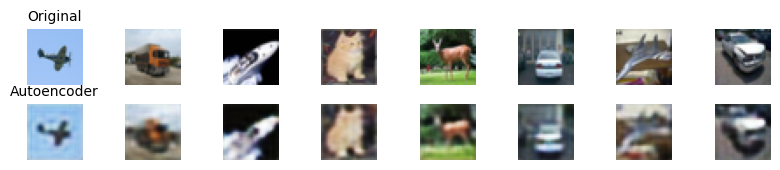

In [108]:
# Plotting images
plot_images([autoencoder], ['Autoencoder'], images = x_test, n = 8)

We can see that each image is reconstructed with an acceptable quality. The autoencoder was able to recognize the patterns and general features of the images.

Now we will calculate the Structural Similarity Index Measure (SSIM). This metric measures the similarity between two images by modeling how the human perceive the images. It works by comparing the luminance, contrast and structure of the images. The resulting score, which ranges from -1 to 1, indicates the quality of the reconstruction.

In [111]:
ssim_score = calculate_ssim(autoencoder, x_test)
print("SSIM score:", ssim_score)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
SSIM score: 0.7858296


We got a SSIM of 0.78 which is a good result that indicates that reconstruction is almost similar to the original image.

## Exercise 2

### Latent space size

Equation:
$$
Size = \left( \frac{W - K + 2P}{S} + 1 \right)^2 * C
$$

Where:
- $W$: Input volume
- $K$: Kernel size (filter size)
- $P$: Padding
- $S$: Stride
- $C$: Number of channels

So:
- $W = 8 x 8 = 8$
- $K = 3 x 3 = 3$
- $P = 1 $
- $S = 1$
- $C = 16$

So:
- $Size = \left( \frac{8 - 3 + 2(1)}{1} + 1 \right)^2 * 16 = 64 * 16 = 1024$




### 2.1 Reducing latent space dimensionality

In [10]:
# Build the autoencoder with small latent space
autoencoder_small_ls = build_autoencoder_small_latent_space()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 4)        │           436 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 12)     │           444 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the autoencoder
train_history_small_ls = train_autoencoder(autoencoder_small_ls, x_train, x_val, epochs=50)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0260 - val_loss: 0.0133
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
# Evaluate the autoencoder
test_loss = evaluate_autoencoder(autoencoder_small_ls, x_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0052
Test Loss: 0.005223670043051243


In [13]:
plot_training_history(train_history_small_ls)

In [14]:
# Show the results
print("\nShowing original vs. reconstructed images:")
compare_autoencoders([autoencoder, autoencoder_small_ls], 
['1st Autoencoder', 'Small Latent Space'], images = x_test, n = 10)


Showing original vs. reconstructed images:


NameError: name 'autoencoder' is not defined

Creating encoder-only model from Functional API...
Generating latent space vectors...
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Flattened latent vector shape: (5000, 256)
Running t-SNE (this may take a few minutes)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.212s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.082173
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.649246
[t-SNE] KL divergence after 1000 iterations: 2.655922
t-SNE complete.
Plotting t-SNE results...


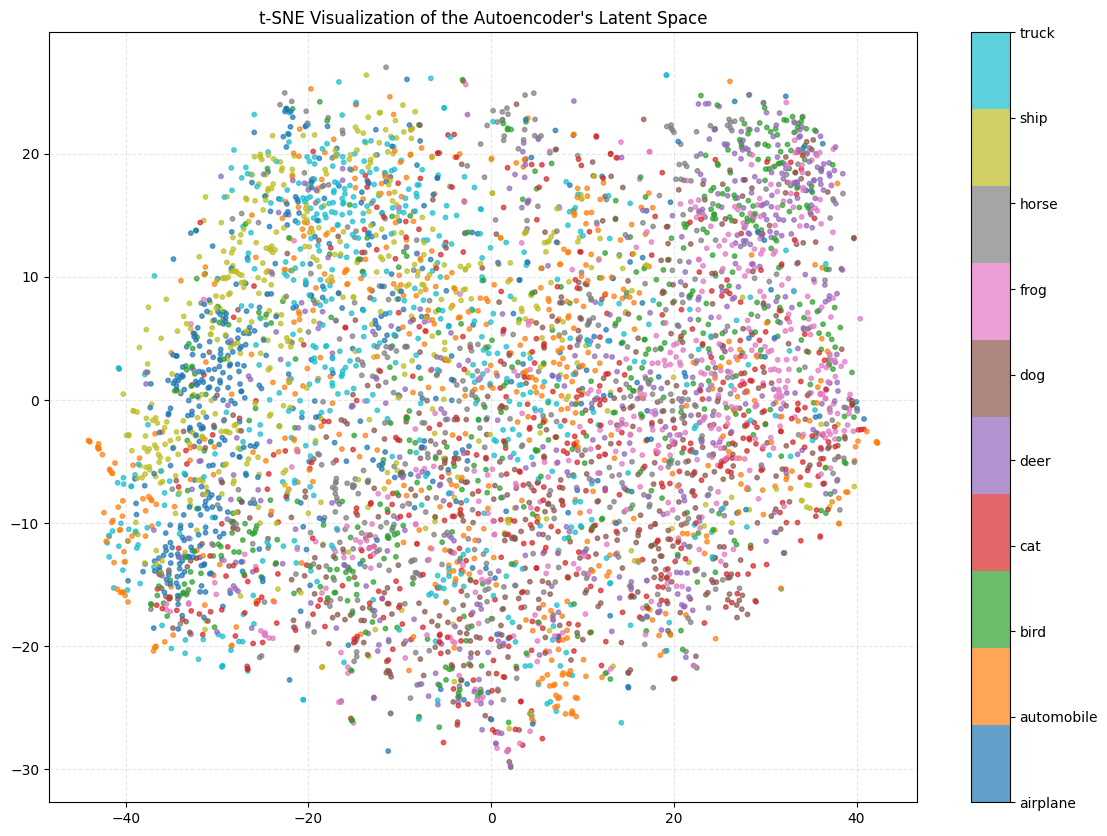

In [17]:
# Call the plotting function with the correct variables
plot_latent_space(autoencoder_small_ls, 'conv2d_2', x_test, y_test)

In [31]:
import pandas as pd
def plot_latent_space_3d(trained_autoencoder, bottleneck_layer_name, images, one_hot_labels, n_samples=5000):
    
    # --- 1. Create the encoder model (Igual que antes) ---
    try:
        model_input = trained_autoencoder.input
        model_output = trained_autoencoder.get_layer(bottleneck_layer_name).output
        encoder_model = Model(inputs=model_input, outputs=model_output)
    except Exception as e:
        print(f"ERROR: Could not create encoder. Layer name correct?")
        print(f"Run 'autoencoder.summary()' to find the name.")
        print(f"Details: {e}")
        return

    if n_samples > len(images): n_samples = len(images)

    print("Generating latent space vectors...")
    x_sample = images[:n_samples]
    y_sample_one_hot = one_hot_labels[:n_samples]
    
    # Convert from one-hot to integers (0, 1, 2...)
    y_sample_int = np.argmax(y_sample_one_hot, axis=1)

    # Pass data through encoder
    latent_vectors = encoder_model.predict(x_sample)
    latent_vectors_flat = latent_vectors.reshape((n_samples, -1))

    # --- 2. Run t-SNE (Igual que antes) ---
    print("Running 3D t-SNE (this may take a while)...")
    tsne = TSNE(n_components=3, perplexity=30, max_iter=1000, verbose=1)
    tsne_results = tsne.fit_transform(latent_vectors_flat)
    print("3D t-SNE complete.")

    # --- 3. Prepare Data for Plotly ---
    print("Creating interactive plot...")
    
    # Convertimos los números (0, 1) a nombres reales ('airplane', 'car')
    # Esto hará que el gráfico sea mucho más fácil de leer al pasar el mouse
    label_names = [cifar10_labels[i] for i in y_sample_int]

    # Creamos un DataFrame de Pandas. Plotly adora los DataFrames.
    df = pd.DataFrame({
        'x': tsne_results[:, 0],
        'y': tsne_results[:, 1],
        'z': tsne_results[:, 2],
        'label': label_names  # Usamos los nombres para la leyenda
    })

    # --- 4. Generate Plotly Chart ---
    fig = px.scatter_3d(
        df, 
        x='x', y='y', z='z',
        color='label',  # Colorea automáticamente según la clase
        title='Latent Space 3D Visualization (CIFAR-10)',
        labels={'label': 'Class'}, # Título de la leyenda
        opacity=0.7,     # Un poco de transparencia ayuda a ver cúmulos densos
        height=800,       # Altura del gráfico en píxeles
        width=1000
    )

    # Ajustes visuales finos
    fig.update_traces(marker=dict(size=3)) # Puntos más pequeños para ver mejor los detalles
    fig.update_layout(
        scene=dict(
            xaxis_title='t-SNE 1',
            yaxis_title='t-SNE 2',
            zaxis_title='t-SNE 3'
        ),
        legend_title_text='Classes'
    )

    fig.show()

In [32]:
# Call the plotting function with the correct variables
plot_latent_space_3d(autoencoder_small_ls, 'conv2d_2', x_test, y_test)

Generating latent space vectors...
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running 3D t-SNE (this may take a while)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.082173
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.554611
[t-SNE] KL divergence after 1000 iterations: 2.424313
3D t-SNE complete.
Creating interactive plot...


In [34]:
evaluate_reconstruction_quality(autoencoder_small_ls, x_test)

Generating reconstructions...
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Calculating metrics...
----------------------------------------
📊 QUALITY METRICS REPORT
----------------------------------------
MSE  (Lower is better):  0.00522
PSNR (Higher is better): 23.36 dB
SSIM (Higher is better): 0.7586 (max 1.0)
----------------------------------------


(np.float32(0.0052236705), np.float32(23.360495), np.float32(0.7586333))

In [50]:
evaluate_reconstruction_quality(autoencoder, x_test)

Generating reconstructions...
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Calculating metrics...
----------------------------------------
📊 QUALITY METRICS REPORT
----------------------------------------
MSE  (Lower is better):  0.00453
PSNR (Higher is better): 23.97 dB
SSIM (Higher is better): 0.7779 (max 1.0)
----------------------------------------


(np.float32(0.0045339535), np.float32(23.965588), np.float32(0.77793133))

### 2.2 Increased filter size

In [47]:
autoencoder_incresed_fs = build_autoencoder_increased_filter_size(filter_size=7)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 8)      │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 12)     │         4,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 16)       │         9,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 12)     │         9,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 3)      │         1,767 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,511 (103.56 KB)

 Trainable params: 26,511 (103.56 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Train the autoencoder
train_history_increased_fs = train_autoencoder(autoencoder_incresed_fs, x_train, x_val, epochs=50)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - loss: 0.0247 - val_loss: 0.0140
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - loss: 0.0132 - val_loss: 0.0113
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - loss: 0.0111 - val_loss: 0.0123
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - loss: 0.0098 - val_loss: 0.0114
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 12/50
188/188

In [49]:
# Evaluate the autoencoder
test_loss = evaluate_autoencoder(autoencoder_incresed_fs, x_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046
Test Loss: 0.004617184400558472


In [50]:
plot_training_history(train_history_small_ls)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


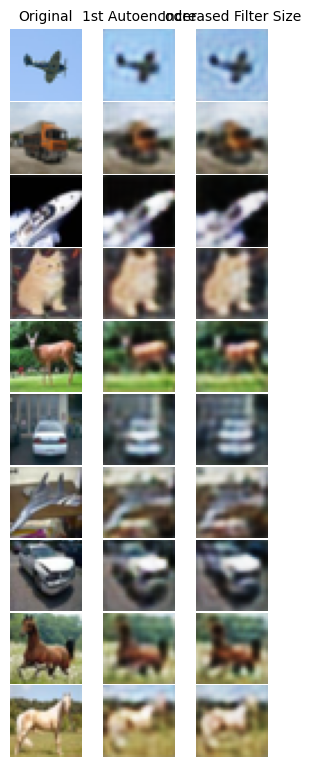

In [69]:
# Show the results
compare_autoencoders([autoencoder, autoencoder_incresed_fs], 
['1st Autoencoder', 'Increased Filter Size'], images = x_test, n = 10)

### 2.3 Changed the downsample method

In [53]:
autoencoder_strided_conv = build_autoencoder_strided_conv()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 12)       │         1,308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 8, 8, 16)       │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 12)     │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,803 (26.57 KB)

 Trainable params: 6,803 (26.57 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Train the autoencoder
train_history_strided_conv = train_autoencoder(autoencoder_strided_conv, x_train, x_val, epochs=50)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0240 - val_loss: 0.0112
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0092 - val_loss: 0.0081
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 

In [55]:
# Evaluate the autoencoder
test_loss = evaluate_autoencoder(autoencoder_incresed_fs, x_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046
Test Loss: 0.004617184400558472


In [ ]:
plot_training_history(train_history_strided_conv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


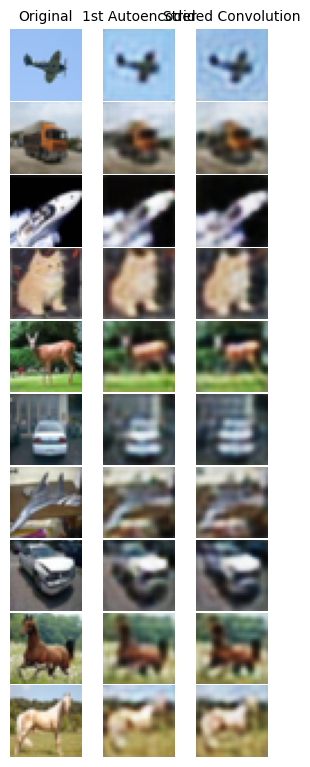

In [68]:
# Show the results
compare_autoencoders([autoencoder, autoencoder_incresed_fs], 
['1st Autoencoder', 'Strided Convolution'], images = x_test, n = 10)

### 2.4 Fewer layers

In [61]:
autoencoder_fewer_layers = build_autoencoder_fewer_layers()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 12)     │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,459 (13.51 KB)

 Trainable params: 3,459 (13.51 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Train the autoencoder
train_history_fewer_layers = train_autoencoder(autoencoder_fewer_layers, x_train, x_val, epochs=50)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0255 - val_loss: 0.0133
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0117 - val_loss: 0.0108
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 

In [63]:
# Evaluate the autoencoder
test_loss = evaluate_autoencoder(autoencoder_fewer_layers, x_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0066
Test Loss: 0.006573445629328489


In [64]:
plot_training_history(train_history_fewer_layers)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


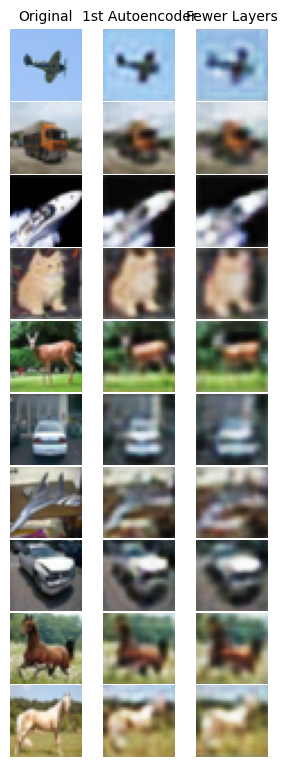

In [67]:
# Show the results
compare_autoencoders([autoencoder, autoencoder_fewer_layers], 
['1st Autoencoder', 'Fewer Layers'], images = x_test, n = 10)

## Exercise 3

In [53]:
def rgb_to_gray(images):
    """Convert RGB [N,32,32,3] → Grayscale [N,32,32,1]."""
    return np.dot(images[...,:3], [0.299, 0.587, 0.114])[..., np.newaxis]

x_train_gray = tf.image.rgb_to_grayscale(x_train) # rgb_to_gray(x_train)
x_val_gray   = tf.image.rgb_to_grayscale(x_val) # rgb_to_gray(x_val) 
x_test_gray  = tf.image.rgb_to_grayscale(x_test) # rgb_to_gray(x_test)

In [54]:
# Build the autoencoder
autoencoder_gray_color = build_grayscale_autoencoder(input_shape=(32, 32, 1))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 16)       │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 12)     │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,767 (18.62 KB)

 Trainable params: 4,767 (18.62 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Train the autoencoder
train_history = train_autoencoder(autoencoder_gray_color, x_train_gray, x_val_gray, epochs=50, y_train = x_train, y_val = x_val)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0282 - val_loss: 0.0156
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0141 - val_loss: 0.0133
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0127 - val_loss: 0.0124
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0121 - val_loss: 0.0119
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0108 - val_loss: 0.0110
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 

In [56]:
# Evaluate the autoencoder
test_loss = evaluate_autoencoder(autoencoder_gray_color, x_test_gray)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0048
Test Loss: 0.004820296075195074


In [57]:
# Plot training history
plot_training_history(train_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


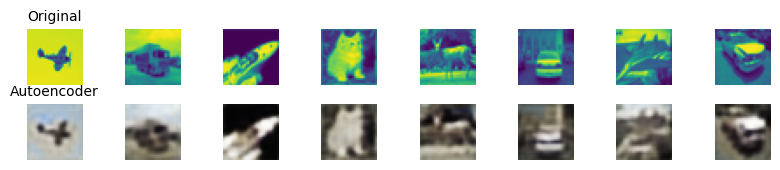

In [59]:
# Plotting images
plot_images([autoencoder_gray_color], ['Autoencoder'], images = x_test_gray, n = 8)